Similarity matrix s(i,k), reflects how suitable data point k is to serve as an exemplar for data point i.
Responsibilty matirx a(i,k), indicates the accumulated evidence for choosing k as the exemplar of point i, taking into account other candidate exemplars. It is a message sent from i to k.
Availabilty matirx a(i,k), indicates the accumulated evidence of how appropriate is for point i to pick k as its exemplar, given the support from other points that k is an exemplar

for any data point i, the point k that maximizes r(i,k)+a(i,k) either represents that point k is an exemplar if k=i or point k is the exemplar of point i

In [1]:
pwd

'/Users/LevinZhu/Documents/OneDrive - Duke University/Duke/Courses/Spring 2020/STA 663 Statistical Computation/Final Project'

https://github.com/GGiecold/Concurrent_AP/blob/master/Concurrent_AP.py
https://github.com/ritchie46/vanilla-machine-learning/blob/master/clustering/affinity_propagation.ipynb
https://www.ritchievink.com/blog/2018/05/18/algorithm-breakdown-affinity-propagation/
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#affinity-propagation

In [2]:
from abc import ABCMeta, abstractmethod
from contextlib import closing
from ctypes import c_double, c_int

In [3]:
import gc
import multiprocessing

In [4]:
import optparse
import psutil
import time
import warnings

In [5]:
# all the imports needed for this blog
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import imageio
from io import BytesIO
%matplotlib inline
import numba
from numba import jit

In [6]:
import sklearn.cluster as cluster
import seaborn as sns
from sklearn import datasets
from sklearn_extra.cluster import KMedoids

sns.set_context('poster')
sns.set_color_codes()

In [7]:
# just to check the memory situation on machine 
def memory():
    """Determine memory specifications of the machine.
    Returns
    -------
    mem_info : dictonary
        Holds the current values for the total, free and used memory of the system.
    """

    mem_info = dict()

    for k, v in psutil.virtual_memory()._asdict().items():
           mem_info[k] = int(v)
           
    return mem_info
mem_free = memory()
mem_free

{'total': 8589934592,
 'available': 3780505600,
 'percent': 56,
 'used': 3555573760,
 'free': 1266196480,
 'active': 1470476288,
 'inactive': 2158157824,
 'wired': 2085097472}

## Data 

In [8]:
# functions for load or save a dictionary
import pickle
def save_obj(obj, obj_name):
    with open('.'+'/'+ obj_name+ '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(obj_name):
    with open('.'+'/'+ obj_name+'.pkl', 'rb') as f:
        return pickle.load(f)    

In [9]:
def make_fake_2d_data(N_data_E_category=[20,20,20,20,20],Scnd_d=2,Visualization=True):
    
    """ 
    a function for creating fake data to check the performance of the affinity propagation algorithm
    User can adjust the number of categories along with the number of data in each one \
    (to chaeck the performance of algorithm for imbalanced data)
    #Scnd_d=2  number of features of the data (for the purpose of visualization,the default is 2)
    """
    np.random.seed(3)
    for i,N in enumerate(N_data_E_category):        
        size = (N, Scnd_d)
        
        if i==0:
            Data_i = np.random.normal(0, 1, size)
            Data=Data_i
        else:
            center = np.random.rand(2) * 10
            Data_i=np.random.normal(center, .5, size)
            Data=np.r_[Data,Data_i]
    
    
    N_category=len(N_data_E_category)  
    if (N_category<8 and Scnd_d==2 and Visualization==True):
        
        color_list=list('bgrcmyk')[:N_category]
        c = [c for s in [v * N for v,N in zip(color_list,N_data_E_category)] for c in list(s)]
        plt.figure(figsize=(15, 6))
        plt.title('Some clusters in 2d space')
        plt.scatter(Data[:, 0], Data[:, 1], c=c)
        plt.show()
    return Data

#### Data Visulaization Functions

In [10]:
def plot_2d_data(Data_X):
    plt.figure(figsize=(15, 6))        
    plt.scatter(Data_X[:, 0], Data_X[:, 1])
    plt.show()
    
    

#### Selecting Dataset from the available ones

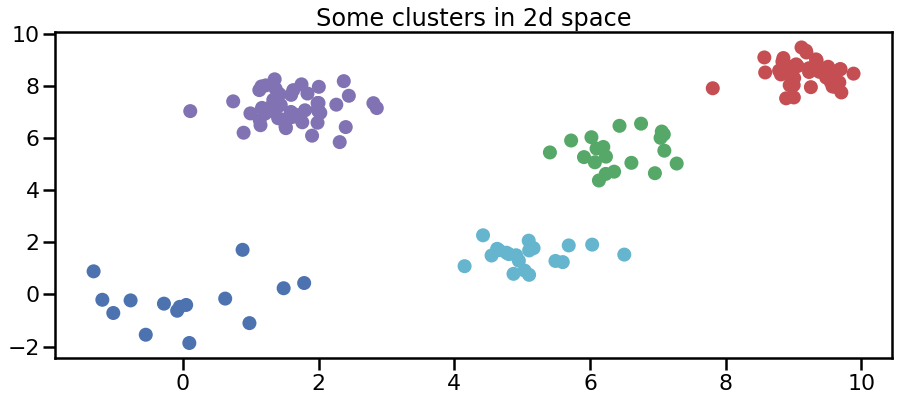

In [11]:
Interested_Dataset=['fake_data','iris_data','Environmental_data'][0]
if Interested_Dataset=='fake_data':
    N_data_E_category_balanced_imbalanced=[[30,30,30,30,30],[15,20,40,20,50]][1]
    Data_Input=make_fake_2d_data(N_data_E_category=N_data_E_category_balanced_imbalanced)
elif Interested_Dataset=='iris_data':    
    iris = datasets.load_iris()
    Data_Input = iris.data
    plot_2d_data(Data_Input)
elif Interested_Dataset=='Environmental_data':
     
    BCF_Elevation=np.load("BCF_Elevation.npy")
    Data_Input =BCF_Elevation[ np.random.choice(np.arange(BCF_Elevation.shape[0]),1000),:]
    plot_2d_data(Data_Input)
else:
    print("the Interested dataset is not available")



### Compute the clustering via Skit-Learn algorithms

In [12]:


plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

def Sklearn_clusters(data, algorithm, args, kwds):
    """ a function for performing clustering with Skit-Learn library"""
    
    start_time = time.time()
    #######
    #labels = algorithm(*args, **kwds).fit_predict(data)
    model=algorithm(*args, **kwds).fit(data)
    labels=model.labels_
    if algorithm==cluster.AffinityPropagation:
        cluster_centers_indices=model.cluster_centers_indices_
        cluster_centers=model.cluster_centers_
    if algorithm==cluster.KMeans:
        cluster_centers=model.cluster_centers_
    if algorithm==KMedoids:
        cluster_centers_indices=model.medoid_indices_
        cluster_centers=model.cluster_centers_
    ####
    end_time = time.time()
    
    
    plot_clusters(data,gapless_labels=labels)
   
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    print('Clustering took {:.2f} s'.format(end_time - start_time))
    if algorithm==cluster.AffinityPropagation:
        return labels,cluster_centers_indices,cluster_centers
    if algorithm==cluster.KMeans:
        return labels,cluster_centers
    if algorithm==KMedoids:
        return labels,cluster_centers_indices,cluster_centers
    else:
        return labels
    

    #plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)

### functions 

In [13]:
def Similarity(x,y):
    """computes the similarity, negative eulidian distance, between two vecotrs"""
    return -np.sum((x-y)**2)


In [14]:
def sentence_similarity(i, k, dictionary):
    '''Returns similarity of sentence i and sentence k, given full dictionary 
    
    From Frey and Dueck (2007):
    
    The similarity of sentence i to sentence k was set to the negative sum of the 
    information-theoretic costs (S5) of encoding every word in sentence i using 
    the words in sentence k and a dictionary of all words in the manuscript. For 
    each word in sentence i, if the word matched a word in sentence k, the coding 
    cost for the word was set to the negative logarithm of the number of words in 
    sentence k (the cost of coding the index of the matched word), and otherwise it 
    was set to the negative logarithm of the number of words in the manuscript 
    dictionary (the cost of coding the index of the word in the manuscript dictionary). 
    A word was considered to match another word if either word was a substring of the other.
    '''
    
    # go through each word in sentence i
    
    sentence_i = i.split()
    sentence_k = k.split()
    
    # return 0 if sentences are the same
    if sentence_i == sentence_k:
        return 0
    
    sim = 0
    for word_i in sentence_i:
        counter = 0
        for word_k in sentence_k:
            counter += 1
            if (word_i in word_k) | (word_k in word_i):
                sim -= np.log(len(sentence_k))
                break
            elif counter < len(sentence_k):
                continue
            else: 
                sim -= np.log(len(dictionary))
                break
                
    return sim


In [15]:
#@jit(nopython=nopython_, cache=cache_)
def pairwise_dists(x, y):
    """ Computing pairwise distances using memory-efficient
        vectorization.

        Parameters
        ----------
        x : numpy.ndarray, shape=(M, D)
        y : numpy.ndarray, shape=(N, D)

        Returns
        -------
        numpy.ndarray, shape=(M, N)
            The square Euclidean distance between each pair of
            rows between `x` and `y`."""
    return  np.sum(x**2,axis=-1).reshape(-1,1)+np.sum(y**2,axis=-1)-2*np.dot(x,y.T) 

In [16]:

#@jit(nopython=nopython_, cache=cache_)
def Initialize_Matrices(X_data,Similarity_metric='Euclidean',memory_efficinet=True,BroadCasting=True,Dictionary=None):
    """create the similarity (S), availability (A) and Responsibility (R) matrices given input data
    X_data >> rows represent observations and columns represent features """
    n=X_data.shape[0]
    S=np.zeros((n,n))
    A=np.zeros((n,n))
    R=np.zeros((n,n))
    if Similarity_metric=='Euclidean':
        if memory_efficinet==False and (BroadCasting==False):
            for i in range(n-1):
                for j in range(i+1,n):
                        S[i,j]=Similarity(X_data[i,:],X_data[j,:]) 
            S=S+S.T
            
        elif (memory_efficinet==False) and (BroadCasting==True):
            S=-np.sum((X_data[None,:,:]-X_data[:,None,:])**2,axis=-1)
        else:
            S=-1*pairwise_dists(X_data, X_data)
        return S,R,A
    if Similarity_metric =='Sentences':
        for i in range(n):
            for j in range(n):
                # here, X_data would be an array of sentences
                S[i,j] = sentence_similarity(X_data[i], X_data[j], Dictionary)
        return S,R,A
    else:
        raise ValueError("The only Predefined Similarity metric is 'Euclidean'.\
 For '%s' metric, a new function should be defined"%Similarity_metric)

In [17]:
def Update_R_loop(S,R,A,temp=None,damping_factor=0.5):
    if temp is None: temp=np.zeros_like(R)
    n=S.shape[0]
    for i in range(n):
        for k in range(n):
            # approach 1
    #         Ids_kp=[kp for kp in list(range(n)) if not kp==k and not kp==i]
    #         temp=np.max(A[i,Ids_kp]+S[i,Ids_kp])
            #approach 2
            temp1=(A[i,:]+S[i,:])
            temp1[i]=-np.inf
            temp1[k]=-np.inf
            temp=np.max(temp1)

            R[i,k]=R[i,k]*damping_factor+(S[i,k]-temp)*(1-damping_factor)
    return R

In [18]:
#@jit(nopython=nopython_, cache=cache_)
def Update_R_Broadcast(S,R,A,temp=None,damping_factor=0.5):
    if temp is None: temp=np.zeros_like(R)
    temp=A+S
    temp.flat[::(temp.shape[0]+1)]=-np.inf #np.fill_diagonal(temp,-np.inf) 
    rows=np.arange(S.shape[0])
    Id_max_E_row=np.argmax(temp,axis=1)
    first_max=temp[rows,Id_max_E_row]
    temp[rows,Id_max_E_row]=-np.inf
    second_max=temp[rows,np.argmax(temp,axis=1)]
    Max_mat_A_plus_S=np.zeros_like(S)+first_max.reshape(-1,1)#[:,None]
    Max_mat_A_plus_S[rows,Id_max_E_row]=second_max
    R=R*damping_factor+(S-Max_mat_A_plus_S)*(1-damping_factor)
    return R

In [19]:
def Update_A_loop(R,A,temp=None,damping_factor=0.5):
    if temp is None: temp=np.zeros_like(R)
    n=R.shape[0]
    for i in range(n):
        for k in range(n):
            
            temp1=np.array(R[:, k]) #R[:,k]+0.0 
            temp1[i]=-np.inf
            temp1[k]=-np.inf

            temp_sum=np.sum(temp1[temp1>0])
            
            if i!=k:
                A[i,k]=(damping_factor)*A[i,k]+(1-damping_factor)*min(0, R[k,k]+temp_sum)
            else:            
                A[i,k]=(damping_factor)*A[i,k]+(1-damping_factor)*temp_sum
    return A

In [20]:
#@jit(nopython=nopython_, cache=cache_)
def Update_A_Broadcast(R,A,temp=None,damping_factor=0.5,Approach_paper=True):
    
    if temp is None: temp=np.zeros_like(R)
    
    if Approach_paper==False:
        temp=np.array(R)
        temp=np.where(temp<0,0,temp)# np.clip(a,0,np.inf) # a[a<0]=0 # np.maximum(R, 0, a)
        #np.fill_diagonal(temp,0)
        temp.flat[::(temp.shape[0]+1)]=0
        temp2=np.sum(temp,axis=0)
        temp=temp2-np.clip(R,0,np.inf) #np.sum(a,axis=0)-np.clip(a,0,np.inf)
        temp=temp+np.diag(R)
        temp[temp>0]=0 # np.clip(a,-np.inf,0)

        #np.fill_diagonal(temp,temp2)
        temp.flat[::(temp.shape[0]+1)]=temp2
    else:
        np.maximum(R, 0, temp)        
        temp.flat[::(temp.shape[0]+1)]=np.diag(R) #np.fill_diagonal(temp,np.diag(R)) #temp.flat[::(temp.shape[0]+1)]=np.diag(R)
        temp=np.sum(temp,axis=0)-temp
        temp2=np.diag(temp).copy()
        temp[temp>0]=0 # np.clip(a,-np.inf,0)
        temp.flat[::(temp.shape[0]+1)]=temp2 #np.fill_diagonal(temp,temp2)#temp.flat[::(temp.shape[0]+1)]=temp2
        
    A=damping_factor*A+(1-damping_factor)*temp
    
    
    return A

In [21]:
# make sure that both approaches of updating R match

S,R,A=Initialize_Matrices(Data_Input)
R_loop=Update_R_loop(S,R,A)
S,R,A=Initialize_Matrices(Data_Input)
R_Broadcast=Update_R_Broadcast(S,R,A)

np.testing.assert_allclose(R_Broadcast,R_loop) #np.allclose(R_Broadcast,R_loop)

In [22]:
# check speed R update
S,R,A=Initialize_Matrices(Data_Input)
%timeit -r3 -n3 Update_R_loop(S,R,A)
S,R,A=Initialize_Matrices(Data_Input)
%timeit -r3 -n3 Update_R_Broadcast(S,R,A)

151 ms ± 1.81 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
194 µs ± 22.8 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [23]:
# make sure that both approaches of updating A match
S,R,A=Initialize_Matrices(Data_Input)
A_b=Update_A_Broadcast(R,A)
S,R,A=Initialize_Matrices(Data_Input)
A=Update_A_loop(R,A)
np.testing.assert_allclose(A,A_b)# np.allclose(A,A_b)

In [24]:
S,R,A=Initialize_Matrices(Data_Input)
%timeit -r3 -n3 Update_A_Broadcast(R,A)
S,R,A=Initialize_Matrices(Data_Input)
%timeit -r3 -n3 Update_A_loop(R,A)

208 µs ± 29.2 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
204 ms ± 9.05 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Cluster Visualization function



In [25]:
def plot_clusters(data,gapless_labels):
    fig = plt.figure(figsize=(15, 5))
    palette = sns.color_palette(palette='deep', n_colors=np.unique(gapless_labels).max() + 1)
    colors = [palette[x] for x in gapless_labels] #[palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.show()

In [26]:
def plot_iteration(iter_i,labels,exemplars,Data,Draw_lines=False):
    """ Here we assume that we are working with 2d data for the purpose of visualization"""
    fig = plt.figure(figsize=(15, 5))
    
    colors = dict(zip(exemplars, cycle('bgrcmyk')))
    
    for i in range(len(labels)):
        X = Data[i][0]
        Y = Data[i][1]
        
        if i in exemplars:
            exemplar = i
            edge = 'k'
            ms = 10
        else:
            exemplar = labels[i]
            ms = 3
            edge = None
            if Draw_lines==True:
                plt.plot([X, Data[exemplar][0]], [Y, Data[exemplar][1]], c=colors[exemplar])
            else:
                plt.plot([Data[exemplar][0]], [Data[exemplar][1]], c=colors[exemplar])
        plt.plot(X, Y, 'o', markersize=ms,  markeredgecolor=edge, c=colors[exemplar])
        

    plt.title('Number of exemplars: %d @ iteration: %d' % (len(exemplars),iter_i))
    return fig

### main function

In [27]:
def affinity_propagation(Data_X_samples, Similarity_metric_='Euclidean',preference=None, max_iter=200,max_err=1e-4,
                         damping=0.5, copy=True, verbose=False,
                         return_n_iter=False,Visulization_track=False,Plot_Clusters=True,Draw_lines=False,Version_Fast=True, 
                         Dictionary=None):
    """
    
    """
    
    Data_X=np.copy(Data_X_samples)
    n_samples=Data_X.shape[0]
    S,R,A=Initialize_Matrices(Data_X,Similarity_metric_,Dictionary=Dictionary)
    

    if preference is None:
        preference = np.median(S)
    if damping < 0.5 or damping >= 1:
        raise ValueError('Based on the suggestion of authors (Brendan J. Frey* and Delbert Dueck 2007) ,\
        damping must be >= 0.5 and < 1')

    preference = np.array(preference)
    S.flat[::(n_samples + 1)] = preference #np.fill_diagonal(S,preference)  #  S.flat[::(n_samples + 1)] = preference
    
    # Intermediate results
    current_sol=np.zeros_like(S)
    temp_arr=np.zeros_like(S)
    
    
    last_sol=np.zeros_like(S)
    current_sol=np.zeros_like(S)
    last_exemplars = np.array([])
    
    # Remove degeneracies
    random_state = np.random.RandomState(0)
    S += ((np.finfo(np.double).eps * S + np.finfo(np.double).tiny * 100) *
          random_state.randn(n_samples, n_samples))
    
    figures=[]
    
    if Version_Fast==True:
        
        
        for it in range(max_iter):

            R=Update_R_Broadcast(S,R,A,temp_arr,damping)
            A=Update_A_Broadcast(R,A,temp_arr,damping)

            current_sol=A+R
            labels = np.argmax(current_sol, axis=1)
            exemplars = np.unique(labels)

            if Visulization_track==True:
                if (np.all(last_exemplars != exemplars)):
                    figures.append(plot_iteration(it,labels,exemplars,Data_X,Draw_lines=Draw_lines))

            if np.allclose(last_sol, current_sol):#np.sqrt(np.sum((last_sol- current_sol)**2)) < max_err:# np.allclose(last_sol, current_sol):
                print(exemplars, it)
                break

            last_sol = current_sol
            last_exemplars = exemplars
        # mapping the labels into a sorted, gapless, list    
        #labels = np.searchsorted(last_exemplars, labels)

        Cluster_Centers=Data_X[last_exemplars]
        
    else:
        
        for it in range(max_iter):

            R=Update_R_loop(S,R,A,temp_arr,damping)
            A=Update_A_loop(R,A,temp_arr,damping)

            current_sol=A+R
            labels = np.argmax(current_sol, axis=1)
            exemplars = np.unique(labels)

            if Visulization_track==True:
                if (np.all(last_exemplars != exemplars)):
                    figures.append(plot_iteration(it,labels,exemplars,Data_X,Draw_lines=Draw_lines))

            if np.allclose(last_sol, current_sol):#np.sqrt(np.sum((last_sol- current_sol)**2)) < max_err:# np.allclose(last_sol, current_sol):
                print(exemplars, it)
                break

            last_sol = current_sol
            last_exemplars = exemplars
        # mapping the labels into a sorted, gapless, list    
        #labels = np.searchsorted(last_exemplars, labels)

        Cluster_Centers=Data_X[last_exemplars]
        
    if Plot_Clusters==True:
        plot_clusters(Data_X,gapless_labels=np.searchsorted(last_exemplars, labels))
        #plot_iteration(it,labels,last_exemplars,Data_X,Draw_lines)
    
    if Visulization_track==True:
        return last_exemplars,labels,Cluster_Centers,it,figures
    else:
        return last_exemplars,labels,Cluster_Centers,it
    

In [28]:
%%time
exemplars,labels,Cluster_Centers,last_iteration=affinity_propagation(Data_Input,max_iter=200,Plot_Clusters=False)

[ 7 21 62 89 98] 81
CPU times: user 93.8 ms, sys: 17.8 ms, total: 112 ms
Wall time: 61.1 ms


In [29]:
%%time
exemplars,labels,Cluster_Centers,last_iteration=affinity_propagation(Data_Input,max_iter=200,Plot_Clusters=False,Version_Fast=False)

[ 7 21 62 89 98] 81
CPU times: user 29 s, sys: 185 ms, total: 29.2 s
Wall time: 30.5 s


In [30]:
21600/41

526.829268292683

[ 7 21 62 89 98] 81


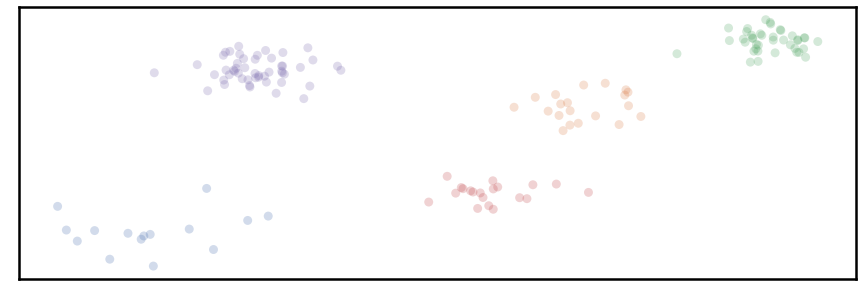

CPU times: user 240 ms, sys: 47.6 ms, total: 287 ms
Wall time: 136 ms


In [31]:
%%time
exemplars,labels,Cluster_Centers,last_iteration=affinity_propagation(Data_Input,max_iter=200,Plot_Clusters=True)

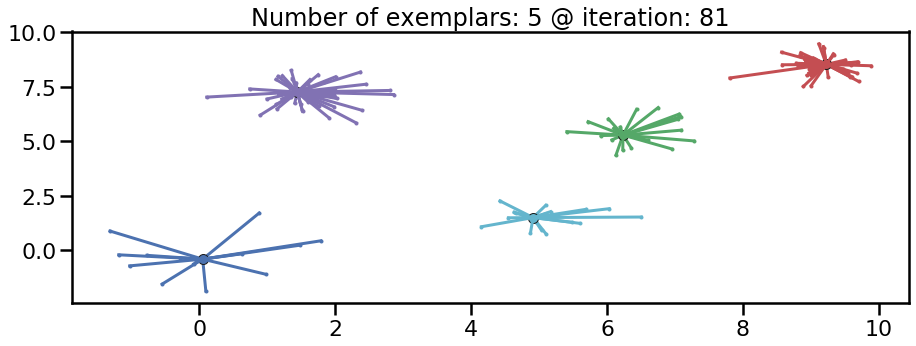

In [32]:
fig= plot_iteration(last_iteration,labels,exemplars,Data_Input,Draw_lines=True)

### Compareing with Skit-Learn

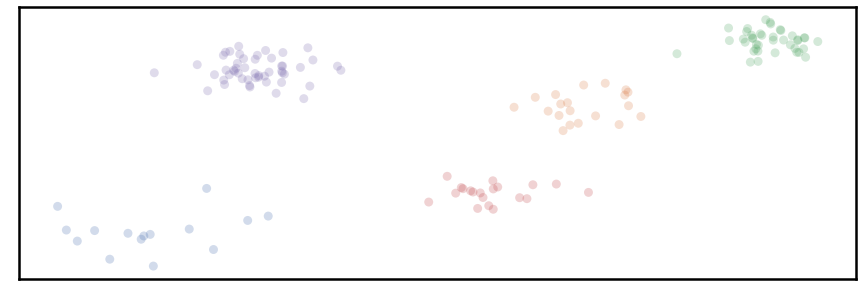

Clustering took 0.09 s
CPU times: user 380 ms, sys: 40.9 ms, total: 421 ms
Wall time: 163 ms


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [33]:
%%time
args=()
kwds={'damping':0.5,'convergence_iter':400}
labels_SK,cluster_centers_indices_SK,cluster_centers_SK=Sklearn_clusters(Data_Input, cluster.AffinityPropagation, args, kwds)
labels_SK

In [34]:
print("Exemplars found by SKlearn: \n",np.unique(cluster_centers_indices_SK))
print("Exemplars found by Implemented Algorithm: \n",np.unique(labels))

Exemplars found by SKlearn: 
 [  7  21  62  89 137]
Exemplars found by Implemented Algorithm: 
 [ 7 21 62 89 98]


In [35]:
print("Cluster centers found by SKlearn: \n",cluster_centers_SK)
print("Cluster centers found by Implemented Algorithm: \n",Cluster_Centers)


Cluster centers found by SKlearn: 
 [[ 0.05003364 -0.40467741]
 [ 6.2357842   5.28411043]
 [ 9.22853636  8.52996483]
 [ 4.91227916  1.50120253]
 [ 1.59422974  6.99662284]]
Cluster centers found by Implemented Algorithm: 
 [[ 0.05003364 -0.40467741]
 [ 6.2357842   5.28411043]
 [ 9.22853636  8.52996483]
 [ 4.91227916  1.50120253]
 [ 1.44358573  7.26196569]]


In [36]:
from sklearn.metrics import pairwise_distances_argmin
def predict_cluster(Data_points,Cluster_centers):
    """ assigning each data point to a cluster by finding the minimum distance between each point and cluster centers"""
    return pairwise_distances_argmin(Data_points,Cluster_centers)

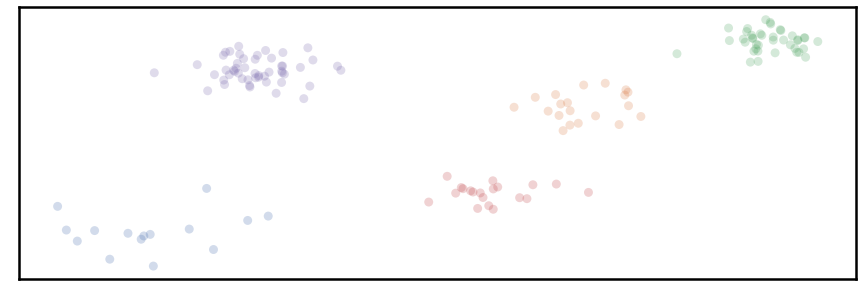

In [37]:
plot_clusters(Data_Input,gapless_labels=predict_cluster(Data_Input,Cluster_Centers) )

### some efforts for speeding up 

In [38]:
from multiprocessing import Pool, Value
from joblib import Parallel
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import multiprocessing as mp

[ 7 21 62 89 98] 81


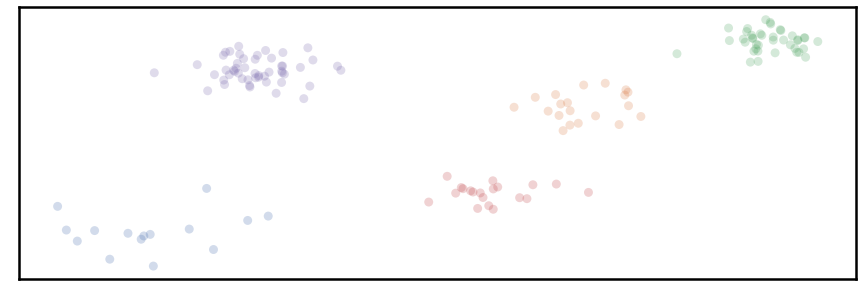

CPU times: user 353 ms, sys: 76.2 ms, total: 430 ms
Wall time: 309 ms


In [39]:
%%time

with ProcessPoolExecutor(max_workers=4) as pool:
    pool.submit(affinity_propagation(Data_Input))

[ 7 21 62 89 98] 81


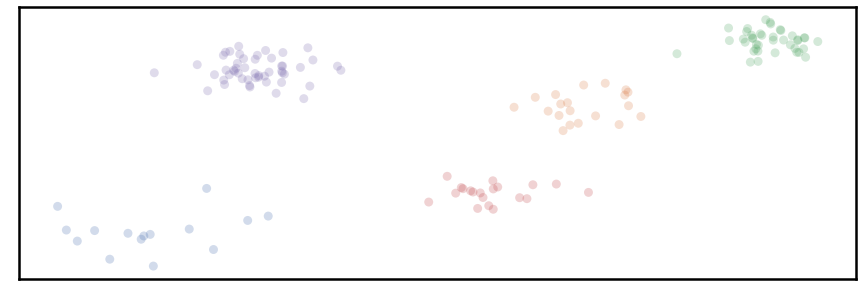

CPU times: user 289 ms, sys: 51.9 ms, total: 341 ms
Wall time: 134 ms


In [40]:
%%time

with ThreadPoolExecutor(max_workers=4) as pool:
    pool.submit(affinity_propagation(Data_Input))

[ 7 21 62 89 98] 81


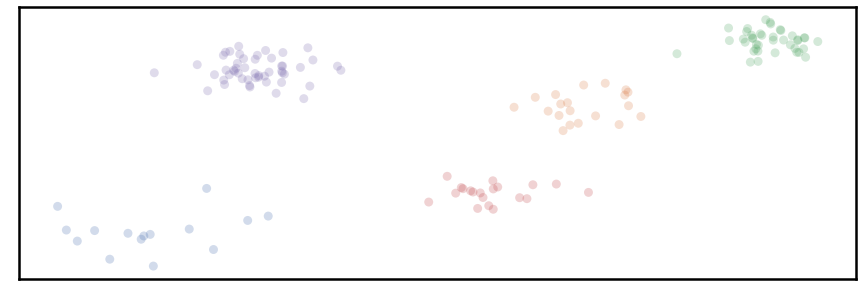

CPU times: user 377 ms, sys: 94.9 ms, total: 472 ms
Wall time: 238 ms


In [41]:
%%time
with Pool(processes=4) as pool:
    #pool.apply(affinity_propagation(Data_Input))
    pool.apply_async(affinity_propagation(Data_Input))

[ 7 21 62 89 98] 81


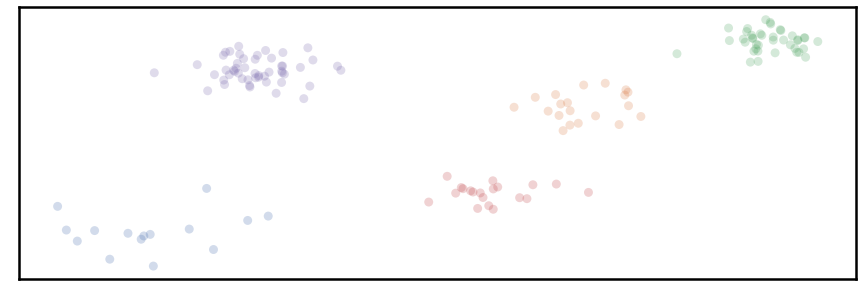

CPU times: user 259 ms, sys: 56.2 ms, total: 316 ms
Wall time: 128 ms


In [42]:
%%time
_=affinity_propagation(Data_Input)

In [43]:
%prun -q -D affinity_propagation.prof affinity_propagation(Data_Input,Plot_Clusters=False)

[ 7 21 62 89 98] 81
 
*** Profile stats marshalled to file 'affinity_propagation.prof'. 


In [44]:
# n=200
# A=np.random.randn((n,n))
# b=np.random.randn(n)
# %timeit np.fill_diagonal(A,b)
# %timeit A[::n+1]=b

In [45]:
import pstats
p = pstats.Stats('affinity_propagation.prof')
p.sort_stats('time', 'cumulative').print_stats()
pass

Sat Apr 25 14:34:22 2020    affinity_propagation.prof

         12554 function calls (11800 primitive calls) in 0.060 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       82    0.013    0.000    0.017    0.000 <ipython-input-20-6cd7b6f5b1e4>:2(Update_A_Broadcast)
       82    0.011    0.000    0.018    0.000 <ipython-input-18-03834b81ab85>:2(Update_R_Broadcast)
      246    0.006    0.000    0.006    0.000 {method 'argmax' of 'numpy.ndarray' objects}
       82    0.005    0.000    0.009    0.000 /Users/LevinZhu/opt/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:2256(within_tol)
      333    0.003    0.000    0.003    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.003    0.003    0.060    0.060 <ipython-input-27-0e513847aa91>:1(affinity_propagation)
 1499/750    0.003    0.000    0.030    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
       82  

        5    0.000    0.000    0.000    0.000 /Users/LevinZhu/opt/anaconda3/lib/python3.7/site-packages/numpy/core/arrayprint.py:1154(__call__)
        1    0.000    0.000    0.000    0.000 /Users/LevinZhu/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3419(median)
        1    0.000    0.000    0.000    0.000 /Users/LevinZhu/opt/anaconda3/lib/python3.7/site-packages/numpy/core/arrayprint.py:1512(_array_str_implementation)
        1    0.000    0.000    0.000    0.000 /Users/LevinZhu/opt/anaconda3/lib/python3.7/site-packages/numpy/core/arrayprint.py:69(_make_options_dict)
        4    0.000    0.000    0.000    0.000 /Users/LevinZhu/opt/anaconda3/lib/python3.7/site-packages/numpy/core/numerictypes.py:293(issubclass_)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.locals}
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(median)
        1    0.000    0.000    0.000    0.000 /Users/LevinZhu/opt/anaconda3/lib/pyth

In [46]:
ipyparallel_lib=False
if ipyparallel_lib==True:
    from ipyparallel import Client
    rc = Client()
    rc.ids
    %timeit rc[:].apply_async(affinity_propagation(Data_Input))

## Make a gif of Affinity Propagation Process

In [47]:
def make_gif(figures, filename, fps=10, **kwargs):
    images = []
    for fig in figures:
        output = BytesIO()
        fig.savefig(output)
        plt.close(fig)  
        output.seek(0)
        images.append(imageio.imread(output))
    imageio.mimsave(filename, images, fps=fps, **kwargs)

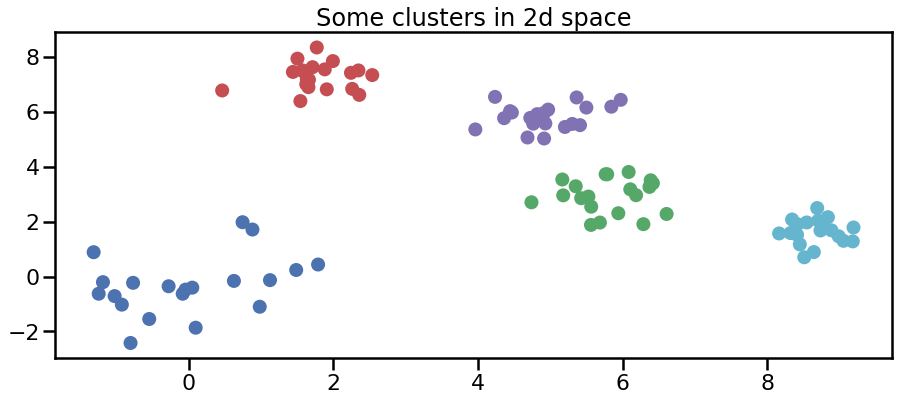

/Users/LevinZhu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[ 7 11 31 53 61 93] 52


In [48]:
_,_,_,_,figures_AF=affinity_propagation(Data_X_samples=make_fake_2d_data(N_data_E_category=[20,20,20,20,20]),\
                                      Plot_Clusters=False,Visulization_track=True,Draw_lines=True)
make_gif(figures_AF, 'Affinity_Propagation.gif', 2)

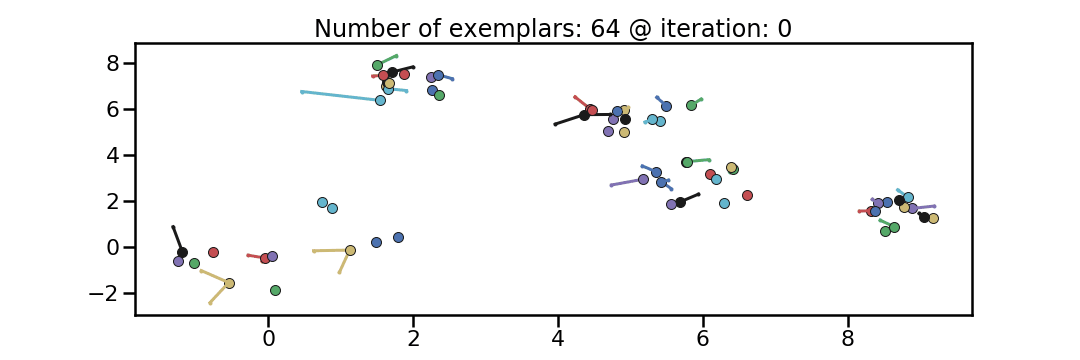

In [49]:
from IPython.display import Image
with open('Affinity_Propagation.gif','rb') as file:
    display(Image(file.read()))

In [50]:
""" Affinity Propagation Clustering of data
    
    Parameters
    ----------
    S : 
        array-like, shape (n_samples, n_samples)
        Matrix of similarities between points
        
    preference : 
        array-like, shape (n_samples,) or float, optional
        Preferences for each point - points with larger values of
        preferences are more likely to be chosen as exemplars. The number of
        exemplars, i.e. of clusters, is influenced by the input preferences
        value. If the preferences are not passed as arguments, they will be
        set to the median of the input similarities (resulting in a moderate
        number of clusters). For a smaller amount of clusters, this can be set
        to the minimum value of the similarities.
        
    max_iter : 
        int, optional, default: 200
        Maximum number of iterations
        
    damping :
        float, optional, default: 0.5
        Damping factor between 0.5 and 1.
        
    Returns
    -------
    cluster_centers_indices : 
        array, shape (n_clusters,)
        index of clusters centers
        
    labels : 
        array, shape (n_samples,)
        cluster labels for each point
        
    n_iter : 
        int
        number of iterations run. Returned only if `return_n_iter` is
        set to True.    
        
    Notes
    -----  
    When the algorithm does not converge, it returns an empty array as
    ``cluster_center_indices`` and ``-1`` as label for each training sample.
        
"""       

' Affinity Propagation Clustering of data\n    \n    Parameters\n    ----------\n    S : \n        array-like, shape (n_samples, n_samples)\n        Matrix of similarities between points\n        \n    preference : \n        array-like, shape (n_samples,) or float, optional\n        Preferences for each point - points with larger values of\n        preferences are more likely to be chosen as exemplars. The number of\n        exemplars, i.e. of clusters, is influenced by the input preferences\n        value. If the preferences are not passed as arguments, they will be\n        set to the median of the input similarities (resulting in a moderate\n        number of clusters). For a smaller amount of clusters, this can be set\n        to the minimum value of the similarities.\n        \n    max_iter : \n        int, optional, default: 200\n        Maximum number of iterations\n        \n    damping :\n        float, optional, default: 0.5\n        Damping factor between 0.5 and 1.\n       

## Comaprison with other clustering algorithm

#### K-Means

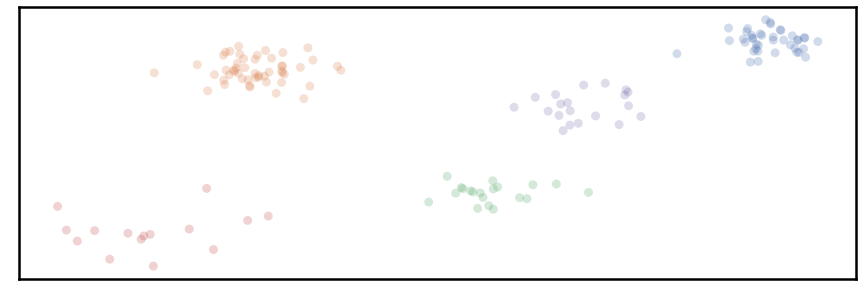

Clustering took 0.03 s


array([0, 1, 2, 3, 4], dtype=int32)

In [51]:
labels_SK,cluster_centers_SK=Sklearn_clusters(Data_Input, cluster.KMeans, (), {'n_clusters':5})
#labels_SK=Sklearn_clusters(Data_Input, cluster.AffinityPropagation, args, kwds)
np.unique(labels_SK)

#### Spectral Clustering

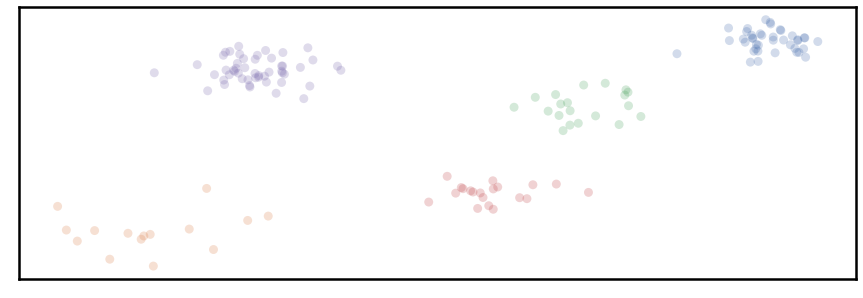

Clustering took 0.05 s


array([0, 1, 2, 3, 4], dtype=int32)

In [52]:
labels_SK=Sklearn_clusters(Data_Input, cluster.SpectralClustering, (), {'n_clusters':5})
np.unique(labels_SK)

#### Agglomerative Clustering

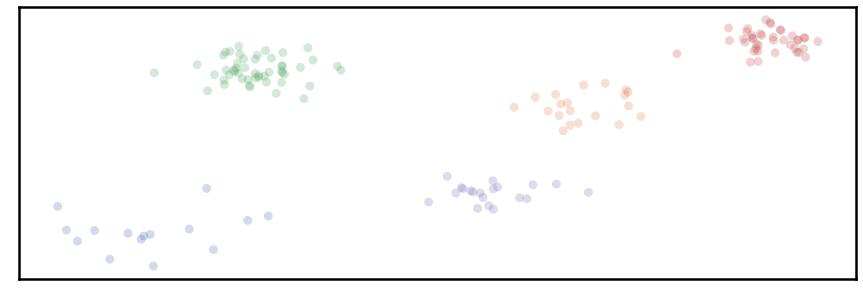

Clustering took 0.00 s


array([0, 1, 2, 3, 4])

In [53]:
labels_SK=Sklearn_clusters(Data_Input, cluster.AgglomerativeClustering, (), {'n_clusters':5, 'linkage':'ward'})
np.unique(labels_SK)

### Gaussin Mixture Model (GMM)

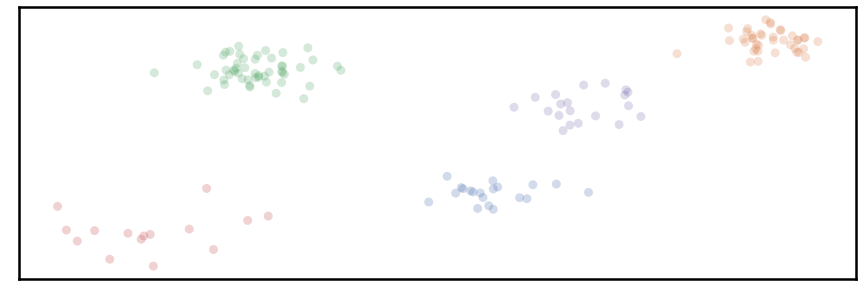

In [54]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=5)
#Predict the clusters on all the data
clusters = model.fit_predict(Data_Input)
plot_clusters(Data_Input,clusters)

In [55]:
pip --version

pip 19.2.3 from /Users/LevinZhu/opt/anaconda3/lib/python3.7/site-packages/pip (python 3.7)
Note: you may need to restart the kernel to use updated packages.


In [56]:
!pip --version

pip 19.2.3 from /Users/LevinZhu/opt/anaconda3/lib/python3.7/site-packages/pip (python 3.7)


In [57]:
!python -m ensurepip --default-pip

Looking in links: /var/folders/1c/dx54z8h931d15_scft_xdfwh0000gp/T/tmpi2jfvt2k


In [58]:
#!python -m pip install --user --upgrade setuptools wheel

## Description of optimization for performance

After profiling the first version of the code, which was written based on the plain implementation of Affinity Propagation as described in the original paper, we found some bottlenecks and significanctly increase the computation time. In what follows, we mention these bottlenecks and explain how we our new implemnetations significanctly enhanced the optimization of the algorithm.   

### a. computing the similarity matrix

The first step in the affinity propagation implmentation is to compute the similarity matrix. Given that in the original paper the negative Eculidiean distance was used as the metric for computing the similarity, we need to have a function that takes an input 2d array $M$ ($n*m$; features in columns and obseravtions in rows) and returns a square matrix $S$ that each element represents this metric between the rows of input data. 


The plain implementaiton was based on using looping for $M$ as a collection of row vectors. Using broadcasting, we were able to compute $S$ around $35$ times faster. While this is a significant improvement, we should note that this appraoch is memory inefficinet because we converted a 2d array to a 3d one and therfore increasing the number of features (columns) could impair the broadcasting optimization. Indeed, our below example shows that by increasing the number of columns from 4 to 12 (keeping number of rows the same) the speed up reduces from 35 times to 16 times. 


To make the broadcasting implementation memory efficinet, we need to eliminate the need for constructing the 3d array. To this aim, we consider the Euclidean distance formula: 


\begin{equation}
\sum_{i=0}^{D-1}{(x_{i} - y_{i})^2} = \sum_{i=0}^{D-1}{x_{i}^2} + \sum_{i=0}^{D-1}{y_{i}^2} - 2\sum_{i=0}^{D-1}{x_{i} y_{i}}
\end{equation}

In this formula, $x$ and $y$ represent the corresponding rows in $M$ and so we need to run this formula for all the pairs. Furthermore, $D$ indicates the number of columns in $M$. We want to compute this formula using broadcasting which means that $x$ and $y$ should represent the same 2d array, $M$. Computing the first two terms would be straightforward using broadcasting and we just need to reshape one of the computed vectors to construct a $n*n$ array when we sume them up. The third term is equivalent to computing matrix multiplication $-2\;(x \cdot y^{T}) $ (Ref [[1]](https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/Broadcasting.html)). 

This memory efficinet implementation could make the computation of $S$ around 110 times faster compared to the plain one while it is not affected by increasing the number of features. 
In the following, we first show that all these three implementations yield the same answer and then compare their computation time  

In [59]:
n,m=1000,4
M=np.random.randn(n,m)
S_plain,_,_=Initialize_Matrices(M,Similarity_metric='Euclidean',memory_efficinet=False,BroadCasting=False)
S_brc,_,_=Initialize_Matrices(M,Similarity_metric='Euclidean',memory_efficinet=False,BroadCasting=True)
S_mef,_,_=Initialize_Matrices(M,Similarity_metric='Euclidean',memory_efficinet=True,BroadCasting=True)
#np.allclose(S_plain,S_mef),np.allclose(S_plain,S_brc)#np.testing.assert_allclose(S_plain,S_mef) 
print("It is %s that the computed similarity matrix \
using looping and broadcasting implementations are equal "%(np.allclose(S_plain,S_brc)))
print("It is %s that the computed similarity matrix \
using looping and vectorizaion implementations are equal "%(np.allclose(S_plain,S_mef)))

%timeit -r3 -n3 Initialize_Matrices(M,Similarity_metric='Euclidean',memory_efficinet=False,BroadCasting=False)
%timeit -r3 -n3 Initialize_Matrices(M,Similarity_metric='Euclidean',memory_efficinet=False,BroadCasting=True)
%timeit -r3 -n3 Initialize_Matrices(M,Similarity_metric='Euclidean',memory_efficinet=True,BroadCasting=True)

It is True that the computed similarity matrix using looping and broadcasting implementations are equal 
It is True that the computed similarity matrix using looping and vectorizaion implementations are equal 
3.14 s ± 84.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
45 ms ± 428 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
11.9 ms ± 277 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [60]:
time_plain=2220
time_brc_ineff=63.1
time_brc_eff=20.5
print("speed up ratio of plain/inefficinet broadcasting = %f"%(time_plain/time_brc_ineff))
print("speed up ratio of plain/efficinet broadcasting = %f"%(time_plain/time_brc_eff))
print("speed up ratio of inefficinet/efficinet broadcasting = %f"%(time_brc_ineff/time_brc_eff))

speed up ratio of plain/inefficinet broadcasting = 35.182250
speed up ratio of plain/efficinet broadcasting = 108.292683
speed up ratio of inefficinet/efficinet broadcasting = 3.078049


In [61]:
n,m=1000,12
M=np.random.randn(n,m)
S_plain,_,_=Initialize_Matrices(M,Similarity_metric='Euclidean',memory_efficinet=False,BroadCasting=False)
S_brc,_,_=Initialize_Matrices(M,Similarity_metric='Euclidean',memory_efficinet=False,BroadCasting=True)
S_mef,_,_=Initialize_Matrices(M,Similarity_metric='Euclidean',memory_efficinet=True,BroadCasting=True)
#np.allclose(S_plain,S_mef),np.allclose(S_plain,S_brc)#np.testing.assert_allclose(S_plain,S_mef) 
print("It is %s that the computed similarity matrix \
using looping and broadcasting implementations are equal "%(np.allclose(S_plain,S_brc)))
print("It is %s that the computed similarity matrix \
using looping and vectorizaion implementations are equal "%(np.allclose(S_plain,S_mef)))

%timeit -r3 -n3 Initialize_Matrices(M,Similarity_metric='Euclidean',memory_efficinet=False,BroadCasting=False)
%timeit -r3 -n3 Initialize_Matrices(M,Similarity_metric='Euclidean',memory_efficinet=False,BroadCasting=True)
%timeit -r3 -n3 Initialize_Matrices(M,Similarity_metric='Euclidean',memory_efficinet=True,BroadCasting=True)

It is True that the computed similarity matrix using looping and broadcasting implementations are equal 
It is True that the computed similarity matrix using looping and vectorizaion implementations are equal 
3.75 s ± 85.3 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
102 ms ± 12.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
14.7 ms ± 792 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [62]:
time_plain=2190
time_brc_ineff=129
time_brc_eff=19.9
print("speed up ratio of plain/inefficinet broadcasting = %f"%(time_plain/time_brc_ineff))
print("speed up ratio of plain/efficinet broadcasting = %f"%(time_plain/time_brc_eff))
print("speed up ratio of inefficinet/efficinet broadcasting = %f"%(time_brc_ineff/time_brc_eff))

speed up ratio of plain/inefficinet broadcasting = 16.976744
speed up ratio of plain/efficinet broadcasting = 110.050251
speed up ratio of inefficinet/efficinet broadcasting = 6.482412


### b. Computing the Responsibility matrix

The second step in the Affinity Propagation algorithm is to compute the responibility matrix, $R$, using the following formula:



\begin{equation}
r(i, k) \leftarrow s(i, k) - \max\limits_{k' s.t. k' \neq k}\{ a(i, k') + s(i, k') \} 
\end{equation}

Unlike $S$, the function for calculating $R$ is called in each iteration and so it is critical to make it as efficinet as possible. The plain calculation of $R$ was based on using nested loops where for each pair of $(i,k)$, a temperory vector holds the summation of $A(i,:)$ and $S(i,:)$ vectors, $i$ and $k$ indices of this vector are populated with negative infinity ( because responsibility matrix does not send message to itself and also $k' \neq k$) and finally the maximum element of the temperory vector is subtracted from the correspondig component in $S$ and $r(i,k)$ is updated. Such a implementation has a high complexity ($O(n^3)$) our goal is to improve the speed using vectorization. 

Given that $S$ matrix is already available, we just need to construct a matrix for the second term, $\max\limits_{k’ s.t. k’ \neq k}{ a(i, k’) + s(i, k’) }$. To this aim, we first store the sum of $A$ and $S$ in a temperory matrix. For each component of this matrix, $(i,k)$, we want to find the maximum element in the entire row excluding the i'th and k'th columns. To exclude the i'th columns for all such pairs, we just need to replace the diangonal components of the temperoray matrix with negative infinity. At this stage, we can compute the maximum element and its corresponding index in each row of the temproray matrix (the first maximum value in each row). For each row in the temperoray matrix, all the columns have the same maximum value except the column corresponding to the index of the maximum value. To take care of this point (ensure that the k'th columns are aslo excluded), we replace the maximum value in each row of the temperory matrix with negative infinity and again compute the maximum element in each row of the updated temproray matrix (they basically represent the second maximum value in each row). Now we can build a matrix for $\max\limits_{k’ s.t. k’ \neq k}{ a(i, k’) + s(i, k’) }$. We first initialize this square matrix with zero and then add the first maximum values to it by broadcasting (so that all the columns would have the same values). Then in each row, the element correponding to the first maximum value is replaced with the second maximum value. Fianlly we add the similarity matrix to this matrix to obtain the responsibility matrix. Our experiments show that this vectorized implementation of updating $R$ is around $180$ times faster than the plain nested loops one.

In the following, we first ensure that both implementation output the same answer and then comapre their computation time.



In [63]:
n,m=500,4
M=np.random.randn(n,m)
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
R_loop=Update_R_loop(S,R,A)
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
R_Broadcast=Update_R_Broadcast(S,R,A)
np.testing.assert_allclose(R_Broadcast,R_loop) 

print("It is %s that the computed responsibility matrix \
using looping and broadcasting implementations are equal "%(np.allclose(R_Broadcast,R_loop)))

It is True that the computed responsibility matrix using looping and broadcasting implementations are equal 


In [64]:
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
%timeit -r3 -n3 Update_R_loop(S,R,A)
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
%timeit -r3 -n3 Update_R_Broadcast(S,R,A)

2.02 s ± 26.9 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
3.39 ms ± 338 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [65]:
print("speed up ratio of plain/vectorization updating R = %f"%(1400/7.85))

speed up ratio of plain/vectorization updating R = 178.343949


In [66]:
n,m=1000,4
M=np.random.randn(n,m)

S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
%timeit -r3 -n3 Update_R_loop(S,R,A)
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
%timeit -r3 -n3 Update_R_Broadcast(S,R,A)

9.65 s ± 1.19 s per loop (mean ± std. dev. of 3 runs, 3 loops each)
21.8 ms ± 2.04 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [67]:
print("speed up ratio of plain/vectorization updating R = %f"%(6310/34.3))

speed up ratio of plain/vectorization updating R = 183.965015


### c. Computing the Availability matrix

The third step in the Affinity Propagation algorithm is to compute the Availability matrix, $A$, using the following formulas for the off-diagonal and diagonal components:

\begin{equation}
a(i, k) \leftarrow \min\{0, r(k,k) + \sum\limits_{i' s.t. i' \notin \{i, k\}}{\max\{0, r(i', k)\}} 
\end{equation}

\begin{equation}
a(k, k) \leftarrow \sum\limits_{i' \neq k}\max(0, r(i', k))
\end{equation}

Like $R$, the availibility matrix is updated at every iteration and so it is critical to write its updating function as efficient as possible. For the plain implementation of this function, we employ nested loops to compute all the components of $A$. For each pair of $i$ and $k$, we check whether it points to a diagonal or off-diagonal component and then use the correponding formula. To compute $\sum\limits_{i' s.t. i' \notin \{i, k\}}{\max ( 0, r(i', k)})$, which is common for both diagonal and off-diagonal components, we create a temproray vector holding the entire k'th column of $R$, set the i'th and k'th elements to negative infinity and then compute the summation of the remaining positive elements of this vector. 
While a diagonal component of $A$ is updated directly with this summation, an off-diagonal one is populated with the minimum between zero and the sum of the summation and the k'th diagonal compoent of $R$.

Although this implementation is pretty readable, it is not computationally efficient and so our goal is optimize it with vectorization. For this aim, we first construct a matrix for $\sum\limits_{i' s.t. i' \notin \{i, k\}}{\max ( 0, r(i', k)})$ term. We initialize a temperory squre matrix with R and then remove the negative value components. To accomodate the $i’ \neq k$ condition, the diagonal components of this matirx are filled with zero. Then we compute the sum along columns of this matrix, which still includes $i’ =k$ row in each column, and store them in a temperoray vector. This vector itself will be used later for the diagonal components of $A$. In order to take care of $i’ \neq k$ condition, we subtract the positive $i’ =k$ components of $R$ in each column from the temperory vector by broadcasting and store it in the temperoray matrix. Afterwards, we add the digonal components of $R$ to this temperory matrix by broadcasting (which is again stored in the temperory matrix) and then remove its positive values. At this stage, the off-diagonal components of the resulting temperory matrix represent the corresponding components of $A$. Fianlly we replace the diagonal components of the temperory matrix with the elements of the temperory vector and now this temperory matrix fully represents $A$. 

This vectorized implementation can provide at least 225 times speed up compared to the plain one. This speed up would become higher as the size of input data increases. as our experiments shows that increasing the number of data points from 500 to 1000 would increase the speed up from 225 times to 300 times.

This vectorized implementation can become even more efficinet by remvoing the steps for replacing the diagonal components of the temperoray matrix with zero (at the begining) and latern replacing it with the digonal components of $R$. To this aim, after initializing the temperory squre matrix with R removing its negative value components, we replace the diagonal compnonets of the temperory matrix with the diagonal components of $R$. Then we compute the sum along the columns of the temperory matrix (get a vector) and subtract the temperory matrix from it and store the result in the temperory matrix. At this stage, the off-digonal components of $R$ are present in the off-diagonal components of the temperory matrix and also the diagonal components of $R$ are absent in the diagonal components of the temperory matrix. Now we can store the diagonal components of the temperory matrix in a temperory vector which will be used later for the diagonal components of $A$. Finally we remove the positive values of the temperory matrix and replace its diagonal components with the temperoy vector. The resulting temperory matrix fully represents $A$.

This improved vectorization can update $A$ around $1.5$ times faster than the earlier vectorization and around $500$ times compared to the nested loops implementation. In what follows, we first show that all the three implementations yield the same output and then compare their run time.

In [68]:
n,m=500,3
M=np.random.randn(n,m)


In [69]:
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
R=Update_R_Broadcast(S,R,A)
A_loop=Update_A_loop(R,A,temp=None,damping_factor=0.5)

In [70]:
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
R=Update_R_Broadcast(S,R,A)
A_bc=Update_A_Broadcast(R,A,temp=None,damping_factor=0.5,Approach_paper=False)

In [71]:
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
R=Update_R_Broadcast(S,R,A)
A_bc_P=Update_A_Broadcast(R,A,temp=None,damping_factor=0.5,Approach_paper=True)

In [72]:
np.allclose(A_bc,A_bc_P),np.allclose(A_loop,A_bc_P),np.allclose(A_loop,A_bc)


(True, True, True)

In [73]:
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
R=Update_R_Broadcast(S,R,A)
%timeit -r3 -n3 Update_A_loop(R,A,temp=None,damping_factor=0.5)

3.24 s ± 221 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [74]:
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
R=Update_R_Broadcast(S,R,A)
%timeit -r3 -n3 Update_A_Broadcast(R,A,temp=None,damping_factor=0.5,Approach_paper=False)

5.91 ms ± 585 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [75]:
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
R=Update_R_Broadcast(S,R,A)
%timeit -r3 -n3 Update_A_Broadcast(R,A,temp=None,damping_factor=0.5,Approach_paper=True)

2.89 ms ± 149 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [76]:
time_plain=2080
time_brc=9.26
time_brc_b=6.33
print("speed up ratio of plain/broadcasting = %f"%(time_plain/time_brc))
print("speed up ratio of plain/better broadcasting = %f"%(time_plain/time_brc_b))
print("speed up ratio of broadcasting/ better broadcasting = %f"%(time_brc/time_brc_b))

speed up ratio of plain/broadcasting = 224.622030
speed up ratio of plain/better broadcasting = 328.593997
speed up ratio of broadcasting/ better broadcasting = 1.462875


In [77]:
n,m=1000,3
M=np.random.randn(n,m)

In [78]:
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
R=Update_R_Broadcast(S,R,A)
%timeit -r3 -n3 Update_A_loop(R,A,temp=None,damping_factor=0.5)

22.6 s ± 721 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [79]:
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
R=Update_R_Broadcast(S,R,A)
%timeit -r3 -n3 Update_A_Broadcast(R,A,temp=None,damping_factor=0.5,Approach_paper=False)

29.7 ms ± 1.76 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [80]:
S,R,A=Initialize_Matrices(M,Similarity_metric='Euclidean')
R=Update_R_Broadcast(S,R,A)
%timeit -r3 -n3 Update_A_Broadcast(R,A,temp=None,damping_factor=0.5,Approach_paper=True)

17.1 ms ± 583 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [81]:
time_plain=12000
time_brc=39.4
time_brc_b=24.2
print("speed up ratio of plain/broadcasting = %f"%(time_plain/time_brc))
print("speed up ratio of plain/better broadcasting = %f"%(time_plain/time_brc_b))
print("speed up ratio of broadcasting/ better broadcasting = %f"%(time_brc/time_brc_b))

speed up ratio of plain/broadcasting = 304.568528
speed up ratio of plain/better broadcasting = 495.867769
speed up ratio of broadcasting/ better broadcasting = 1.628099


### d. Other Python implementations

Through profiling our code, we also noticed that the code can run even faster by using some alternative ways for replacing the digonal components and removing the positive values in a matrix. Here are our experiments: 

In [82]:
n=10000
Temp=np.random.randn(n,n)
b=np.random.randn(n)
Temp1=Temp.copy()

np.fill_diagonal(Temp1,b*b)
Temp.flat[::(n + 1)]=b*b
print(np.allclose(Temp1,Temp))
%timeit -r3 -n3 np.fill_diagonal(Temp1,b*b)
%timeit -r3 -n3 Temp.flat[::(n+1)]=b*b


True
The slowest run took 5389.10 times longer than the fastest. This could mean that an intermediate result is being cached.
252 ms ± 356 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
The slowest run took 4.95 times longer than the fastest. This could mean that an intermediate result is being cached.
331 µs ± 241 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [83]:
n=1000
Temp=np.random.randn(n,n)
Temp1=Temp.copy()
Temp2=Temp.copy()
Temp1[Temp1>0]=0 #
Temp2=np.clip(Temp2,-np.inf,0)
print(np.allclose(Temp1,Temp2))

Temp=np.random.randn(n,n)
Temp1=Temp.copy()
Temp2=Temp.copy()
%timeit -r3 -n3 np.clip(Temp2,-np.inf,0)
%timeit -r3 -n3 Temp1[Temp1>0]=0

True
4.33 ms ± 743 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
2.15 ms ± 556 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Environmental data

In [84]:
Envirnonmental_Data_dic=load_obj('Envirnonmental_Data')
Envirnonmental_Data_dic

{'dem': array([[1588.9183  , 1677.6432  , 1656.2432  , ..., 1611.0812  ,
         1609.4529  , 1607.8513  ],
        [1614.8094  , 1647.1166  , 1567.0974  , ..., 1607.8534  ,
         1606.7502  , 1605.412   ],
        [1571.3574  , 1543.9697  , 1545.6289  , ..., 1604.6162  ,
         1603.6112  , 1602.8593  ],
        ...,
        [ 112.668274,   94.585144,   83.91435 , ..., 2094.5278  ,
         1858.3633  , 1639.9668  ],
        [ 139.00487 ,  113.679   ,   91.71291 , ..., 1768.0704  ,
         1619.9907  , 1559.3394  ],
        [ 171.27051 ,  141.87949 ,  109.29649 , ..., 1536.9166  ,
         1409.3015  , 1334.4492  ]], dtype=float32),
 'ppt': array([[1247.77    , 1261.6675  , 1271.1284  , ...,  126.94334 ,
          127.1075  ,  127.2425  ],
        [1243.56    , 1258.9551  , 1277.145   , ...,  126.895004,
          127.055   ,  127.207504],
        [1228.3867  , 1249.72    , 1273.7289  , ...,  126.88333 ,
          127.06833 ,  127.229996],
        ...,
        [ 190.56    ,  18

In [85]:
#np.random.choice(np.arange(Envirnonmental_Data_dic['lat'].shape[0]),5000)
Envirnonmental_Data_dic['lat'].shape,Envirnonmental_Data_dic['dem'].shape

((200, 300), (200, 300))

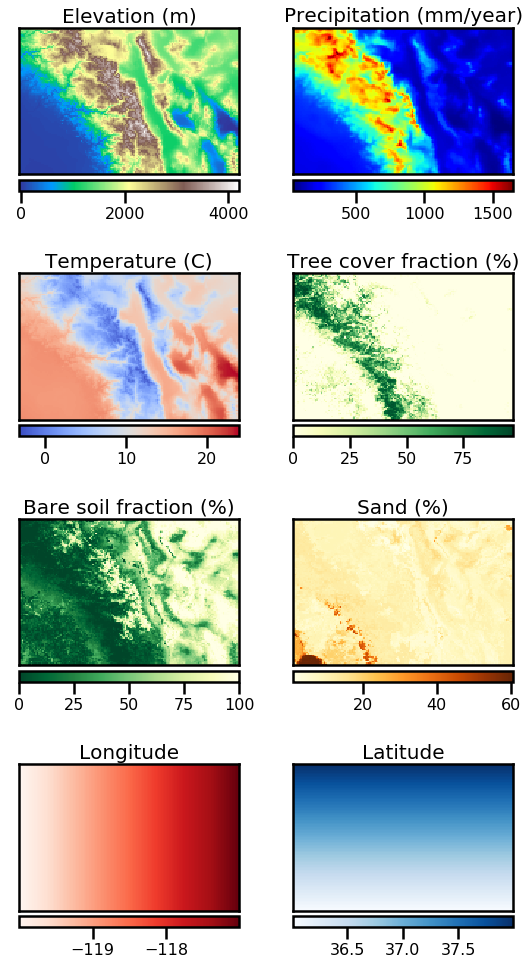

In [86]:
info = {'dem':{'cmap':'terrain','title':'Elevation (m)'},
        'ppt':{'cmap':'jet','title':'Precipitation (mm/year)'},
        'sand':{'cmap':'YlOrBr','title':'Sand (%)'},
        'tcf':{'cmap':'YlGn','title':'Tree cover fraction (%)'},
        'bcf':{'cmap':'YlGn_r','title':'Bare soil fraction (%)'},
        'tmean':{'cmap':'coolwarm','title':'Temperature (C)'},
        'lat':{'cmap':'Blues','title':'Latitude'},
        'lon':{'cmap':'Reds','title':'Longitude'}}
plt.figure(figsize=(8,14))
i = 0
for var in Envirnonmental_Data_dic:
    i += 1
    #print(i)
    plt.subplot(4,2,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Envirnonmental_Data_dic[var][::2,::2],cmap=plt.get_cmap(info[var]['cmap']))
    cb = plt.colorbar(orientation='horizontal',pad=0.03)
    cb.ax.tick_params(labelsize=16)
    plt.title(info[var]['title'],fontsize=20)
plt.tight_layout()
plt.show()

### Focus: Bare cover fraction vs Elevation

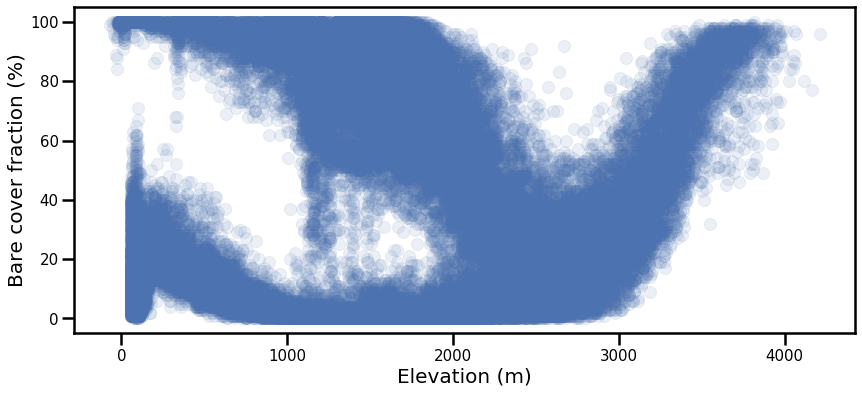

In [87]:
plt.figure(figsize=(14,6))
plt.plot(Envirnonmental_Data_dic['dem'],Envirnonmental_Data_dic['bcf'],'bo',alpha=0.1)
plt.xlabel('Elevation (m)',fontsize=20)
plt.ylabel('Bare cover fraction (%)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()        

It is common in environmental data that we do not have a feature value in all the pixels in a map (latitudes and longitudes) and so the goal is to estimate unknown pixels with the known nearby ones. Another scenario is that the resolution of map is high and we are interested to reduce the resolution (due to the limitation in the computational resources) and so the goal is to minimize lossy compression. To tackle such problems, one idea is to employ the clustering algorithms (such K-Means) and then for each cluter assign the value of the cluster center to all the points that belong to that cluster. In what follows, we perfom this approch on Bare fraction and Elevation maps using both the K-means and the (developed) Affinity propagation algorithms. We train the clustering algorithms with a small random sample of original data and find the cluster centers and then predict which cluster each data point belongs to by finding the minimum Euclidean distance between them.


In [88]:
# We just use a small number of our data to fit the cluster
N_Data_fit=1000
idx = np.random.choice(np.arange(Envirnonmental_Data_dic['dem'].size),N_Data_fit)
v1 = Envirnonmental_Data_dic['dem'].reshape(Envirnonmental_Data_dic['dem'].size)
v2 = Envirnonmental_Data_dic['bcf'].reshape(Envirnonmental_Data_dic['bcf'].size)
#Create data for scikit-learn
X = np.stack((v1,v2)).T
# standardize the data
Xn = (X - np.mean(X,axis=0))/(np.std(X,axis=0))
Xns = Xn[idx,:] # only part of data is used for fitting the model

vmin_dem = np.min(Envirnonmental_Data_dic['dem'])
vmax_dem = np.max(Envirnonmental_Data_dic['dem'])

vmin_bcf = np.min(Envirnonmental_Data_dic['bcf'])
vmax_bcf = np.max(Envirnonmental_Data_dic['bcf'])

## fit and prediction using K-Means

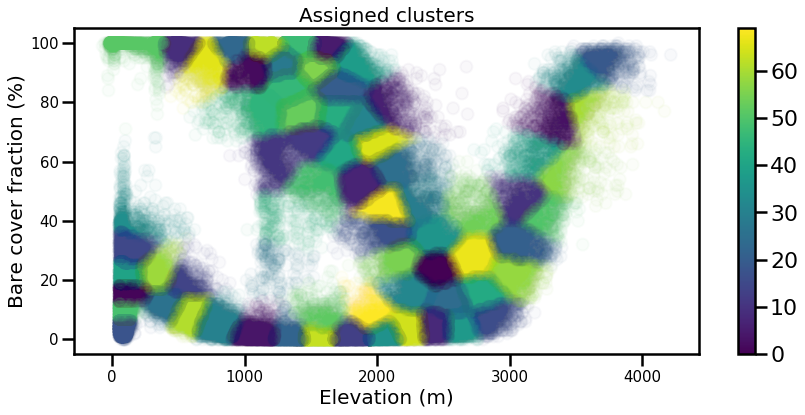

In [89]:

#Define the number of clusters
k = 70
np.random.seed(1)
model = cluster.KMeans(n_clusters=k)
#Subsample data to fit the model (minimize computation)
#Fit the model
model.fit(Xns)
#Predict the clusters on all the data
clusters_Kmeans = model.predict(Xn)
plt.figure(figsize=(14,6))
plt.title('Assigned clusters',fontsize=20)
plt.scatter(Envirnonmental_Data_dic['dem'].reshape(Envirnonmental_Data_dic['dem'].size),\
            Envirnonmental_Data_dic['bcf'].reshape(Envirnonmental_Data_dic['bcf'].size),
            c=clusters_Kmeans,cmap=plt.get_cmap('viridis'),alpha=0.03)
cb = plt.colorbar()
#Ensure the alpha of the colorbar is 1.0
cb.set_alpha(1.0)
cb.draw_all()
plt.xlabel('Elevation (m)',fontsize=20)
plt.ylabel('Bare cover fraction (%)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

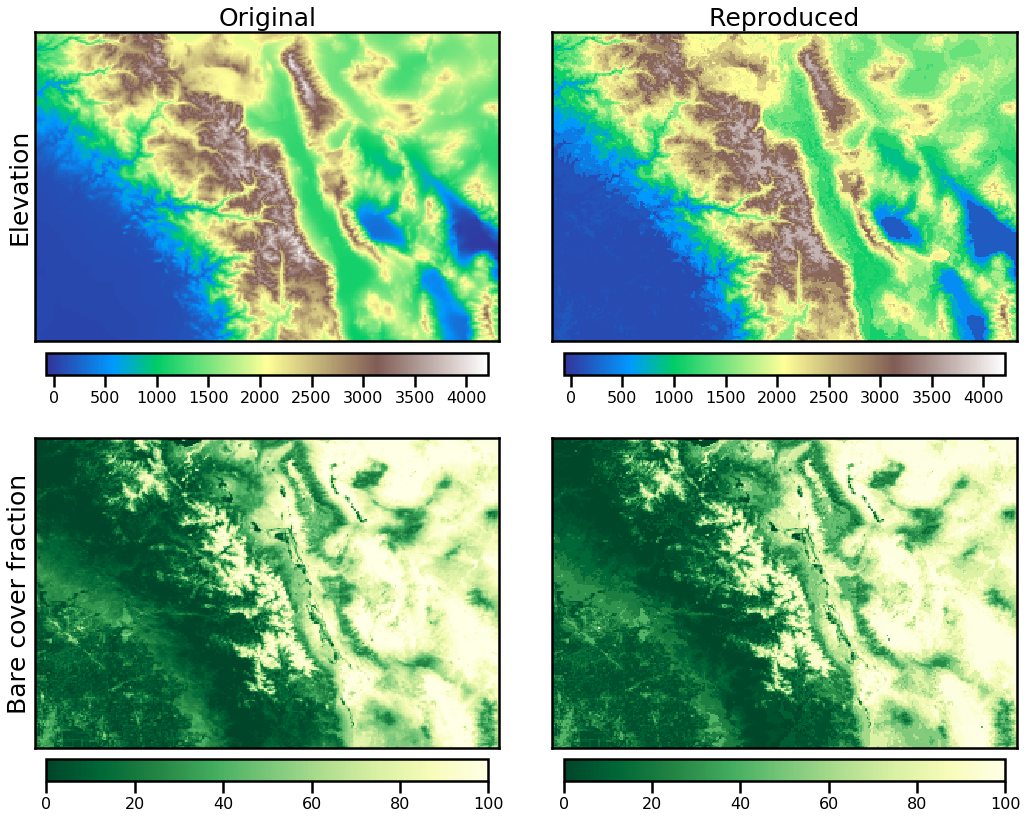

In [90]:
#Assign the cluster centroid values to each cluster
Xpred_Kmeans= np.copy(X)
for i in range(k):
    m = clusters_Kmeans == i
    Xpred_Kmeans[m,:] = np.mean(X[m,:],axis=0)
dem_pred_Kmeans = Xpred_Kmeans[:,0].reshape(Envirnonmental_Data_dic['dem'].shape)
bcf_pred_Kmeans = Xpred_Kmeans[:,1].reshape(Envirnonmental_Data_dic['bcf'].shape)
#Create a figure comparing them

plt.figure(figsize=(15,12))
plt.subplot(221)
plt.imshow(Envirnonmental_Data_dic['dem'],vmin=vmin_dem,vmax=vmax_dem,cmap=plt.get_cmap('terrain'))
plt.ylabel('Elevation',fontsize=25)
plt.title('Original',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(222)
plt.title('Reproduced',fontsize=25)
plt.imshow(dem_pred_Kmeans,vmin=vmin_dem,vmax=vmax_dem,cmap=plt.get_cmap('terrain'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)

plt.subplot(223)
plt.imshow(Envirnonmental_Data_dic['bcf'],vmin=vmin_bcf,vmax=vmax_bcf,cmap=plt.get_cmap('YlGn_r'))
plt.ylabel('Bare cover fraction',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(224)
plt.imshow(bcf_pred_Kmeans,vmin=vmin_bcf,vmax=vmax_bcf,cmap=plt.get_cmap('YlGn_r'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()

## fit and prediction using developed Affinity Propagation

[  0  11  30  32  39  45  49  58  64  68  81  91  97 122 133 154 155 191
 201 208 209 212 225 238 241 244 248 264 276 284 292 321 332 344 345 348
 355 371 382 395 422 423 427 428 430 437 439 461 479 514 515 517 525 537
 538 547 552 569 570 573 590 597 606 616 621 622 633 640 659 668 674 683
 730 737 746 749 755 759 762 766 769 782 793 799 802 812 815 827 828 841
 842 849 857 859 876 886 888 901 921 922 928 935 938 941 961 976 980 984
 987 999] 69


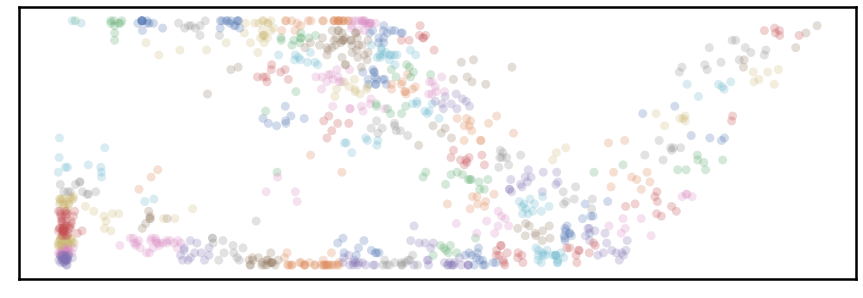

CPU times: user 8.75 s, sys: 741 ms, total: 9.49 s
Wall time: 3.02 s


In [91]:
%%time
exemplars,labels,Cluster_Centers,last_iteration=affinity_propagation(Xns,preference=-0.1,max_iter=200,Plot_Clusters=True)

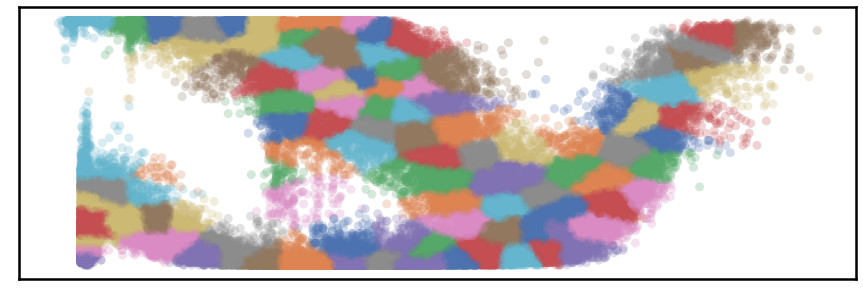

number of clusters found by affinity propagation= 110


In [92]:
Predicted_labels_AF=predict_cluster(Xn,Cluster_Centers)
plot_clusters(Xn,gapless_labels=Predicted_labels_AF )
print("number of clusters found by affinity propagation=",len(exemplars))

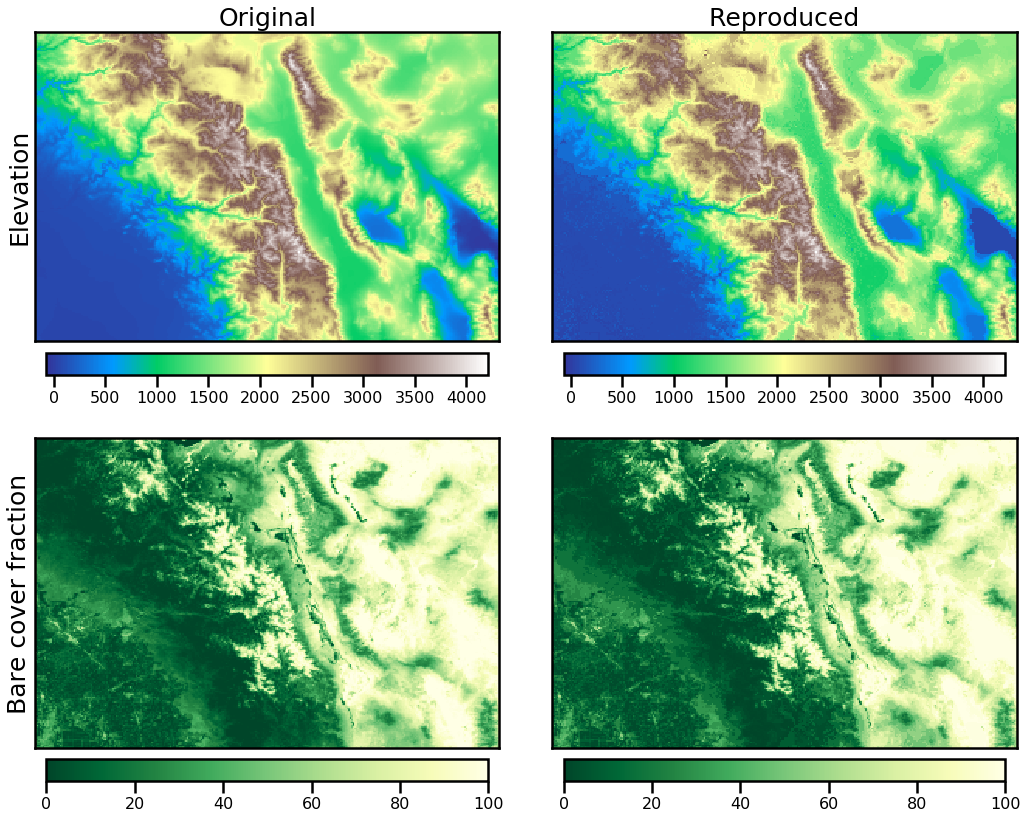

In [93]:
#Assign the cluster centroid values to each cluster
Xpred_AF = np.copy(X)
for i in range(k):
    m =  Predicted_labels_AF == i
    Xpred_AF[m,:] = np.mean(X[m,:],axis=0)
dem_pred_AF = Xpred_AF[:,0].reshape(Envirnonmental_Data_dic['dem'].shape)
bcf_pred_AF = Xpred_AF[:,1].reshape(Envirnonmental_Data_dic['bcf'].shape)
#Create a figure comparing them
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.imshow(Envirnonmental_Data_dic['dem'],vmin=vmin_dem,vmax=vmax_dem,cmap=plt.get_cmap('terrain'))
plt.ylabel('Elevation',fontsize=25)
plt.title('Original',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(222)
plt.title('Reproduced',fontsize=25)
plt.imshow(dem_pred_AF,vmin=vmin_dem,vmax=vmax_dem,cmap=plt.get_cmap('terrain'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
vmin = np.min(Envirnonmental_Data_dic['bcf'])
vmax = np.max(Envirnonmental_Data_dic['bcf'])
plt.subplot(223)
plt.imshow(Envirnonmental_Data_dic['bcf'],vmin=vmin_bcf,vmax=vmax_bcf,cmap=plt.get_cmap('YlGn_r'))
plt.ylabel('Bare cover fraction',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(224)
plt.imshow(bcf_pred_AF,vmin=vmin_bcf,vmax=vmax_bcf,cmap=plt.get_cmap('YlGn_r'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()

In our reasearch, we employ KGE, Kling Gupta Efficieny, as a metric to check the quality of the reduced map. This metric is defined as follows: 

<br>

$$\text{KGE} = 1 - \sqrt{(\rho-1)^2 + (\frac{\sigma_{org}}{\sigma_{sim}} - 1)^2 + (\frac{\mu_{org}}{\mu_{sim}} - 1)^2}$$

> Where $\rho$ is the Pearson correlation between the original and simulated maps, $\sigma_x$ is the standard deviation of a given map, and $\mu_x$ is the arithmetic mean of a given map.

In [94]:
import scipy
def calculate_kge(model,obs):
    rho = scipy.stats.pearsonr(model.reshape(model.size),obs.reshape(obs.size))[0]
    alpha = np.std(obs)/np.std(model)
    beta = np.mean(obs)/np.mean(model)
    kge = 1 - ((1-rho)**2 + (1-alpha)**2 + (1-beta)**2)**0.5
    return kge

In [95]:
print("KGE for the Elevation map using Affinity Propagation = \n",calculate_kge(Envirnonmental_Data_dic['dem'],dem_pred_AF))
print("KGE for the Elevation map using K-means = \n",calculate_kge(Envirnonmental_Data_dic['dem'],dem_pred_Kmeans))

print("KGE for the Bare cover fraction map using Affinity Propagation= \n",calculate_kge(Envirnonmental_Data_dic['bcf'],bcf_pred_AF))
print("KGE for the Bare cover fraction map using K-means= \n",calculate_kge(Envirnonmental_Data_dic['bcf'],bcf_pred_Kmeans))


KGE for the Elevation map using Affinity Propagation = 
 0.9978969588492943
KGE for the Elevation map using K-means = 
 0.9947332377850371
KGE for the Bare cover fraction map using Affinity Propagation= 
 0.9977124111972003
KGE for the Bare cover fraction map using K-means= 
 0.9949538108566405


### New Data

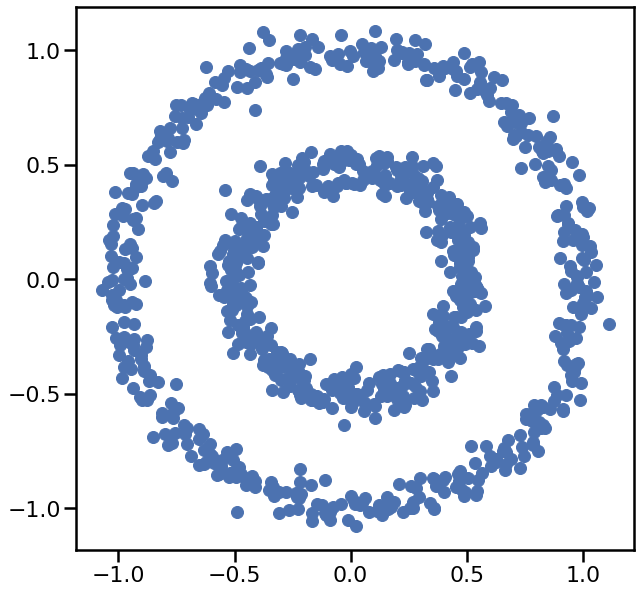

In [96]:
import sklearn.datasets
n_samples = 1000
X = sklearn.datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)[0]
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1],'bo')
plt.show()

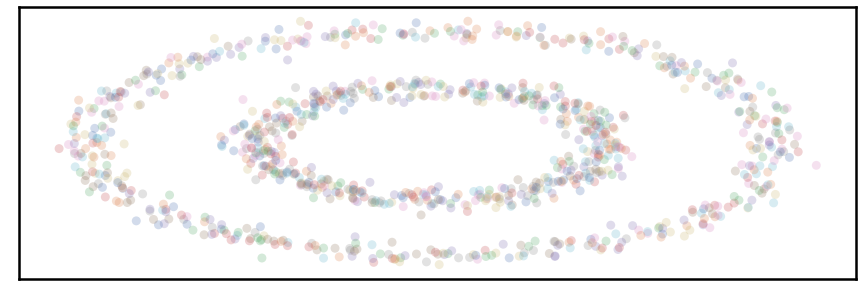

CPU times: user 23.9 s, sys: 2.12 s, total: 26 s
Wall time: 8.46 s


In [97]:
%%time
exemplars,labels,Cluster_Centers,last_iteration=affinity_propagation(X,preference=-100,max_iter=200,Plot_Clusters=True)

In [98]:
len(exemplars)

1000

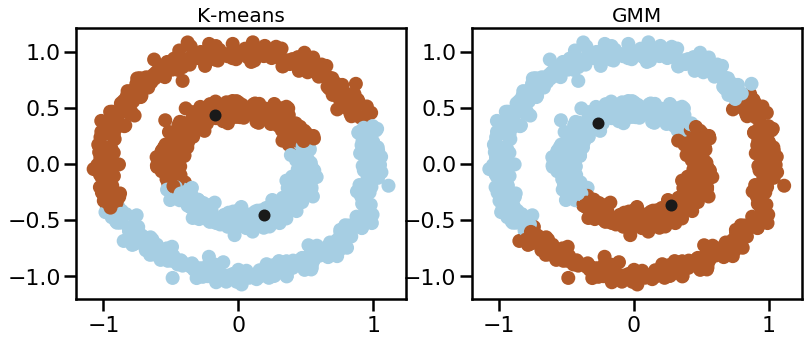

In [99]:

#Set 2 clusters
k = 2
#K-means
model = sklearn.cluster.KMeans(n_clusters=k)
#Fit the model
model.fit(X)
#Predict the clusters on all the data
clusters = model.predict(X)
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.title('K-means',fontsize=20)
plt.scatter(X[:,0],X[:,1],c=clusters,cmap=plt.get_cmap('Paired'))
plt.scatter(model.cluster_centers_[:,0],model.cluster_centers_[:,1],c='k',s=100)
#GMM
model = GaussianMixture(n_components=k)
#Fit the model
model.fit(X)
#Predict the clusters on all the data
clusters = model.predict(X)
plt.subplot(122)
plt.title('GMM',fontsize=20)
plt.scatter(X[:,0],X[:,1],c=clusters,cmap=plt.get_cmap('Paired'))
plt.scatter(model.means_[:,0],model.means_[:,1],c='k',s=100)
plt.show()

In [100]:
cluster.DBSCAN?

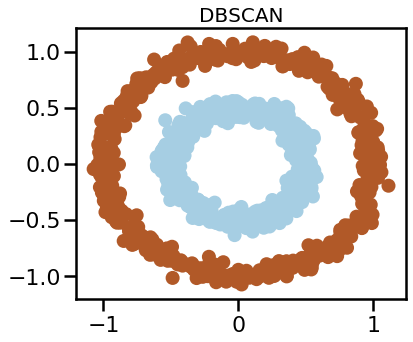

In [101]:
Xt=X[:1000,:]
#Set 2 clusters
k = 2
#model = sklearn.cluster.AgglomerativeClustering(n_clusters=k,linkage='single')
model = cluster.DBSCAN(eps=0.15, min_samples=5)
#Predict the clusters on all the data
clusters = model.fit_predict(Xt)
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.title('DBSCAN',fontsize=20)
plt.scatter(Xt[:,0],Xt[:,1],c=clusters,cmap=plt.get_cmap('Paired'))
plt.show()